# Open Circular Port Graph Examples

In [1]:
using AlgebraicDynamics.DWDDynam
using AlgebraicDynamics.CPortGraphDynam
using AlgebraicDynamics.CPortGraphDynam: draw, barbell, gridpath, grid, meshpath

using Catlab
using Catlab.WiringDiagrams
using Catlab.WiringDiagrams.CPortGraphs
using Catlab.Theories
using Catlab.CategoricalAlgebra

using OrdinaryDiffEq
using DynamicalSystems
using Plots, Plots.PlotMeasures

using PrettyTables

## SIR Epidemiology Model

An SIR epidemiology model has three types of people: susceptible, infected, and recovered. When a susceptible person interacts with infected person, the susceptible person also becomes infected. Over time infected people  recover. Transition rates determine the how frequently susceptible people come into contact with infected people and how fast infected people recover. The system evolves according to the law of mass action.

In a multi-city SIR model, each city has susceptible, infected, and recovered populations. To see the spread of the disease we will consider both susceptible and infected people moving between cities. To define a multi-city SIR model, we can compose multiple single-city SIR models using the composition syntax of open CPGs. The composition pattern will consist of three boxes each of which will be filled by a single-city SIR model. Ports expose the susceptible and infected populations of each city. One set of wires connect the susceptible and infected populations of cities 1 and 2. A second set of wires connect the susceptible and infected popuation of cities 2 and 3.

In [2]:
# Define the composition pattern
d₀ = OpenCPortGraph()
add_parts!(d₀, :Box, 1)
d₁ = barbell(2)
F = ACSetTransformation((Box=[2],), d₀, d₁)
G = ACSetTransformation((Box=[1],), d₀, d₁)
d₂ = apex(pushout(F,G))

# Define the primitive systems
β, μ, α₁, α₂ = 0.4, 0.4, 0.01, 0.01

sirfuncb = (u,x,p,t)->[-β*u[1]*u[2] - α₁*(u[1]-x[1]), # Ṡ
                        β*u[1]*u[2] - μ*u[2] - α₂*(u[2]-x[2]), #İ
                        μ*u[2] # Ṙ
                        ]
sirfuncm = (u,x,p,t)->[-β*u[1]*u[2] - α₁*(u[1]-(x[1]+x[3])/2),
                        β*u[1]*u[2] - μ*u[2] - α₂*(u[2]-(x[2]+x[4])/2),
                        μ*u[2]
                       ]

boundary  = ContinuousMachine{Float64}(2,3,sirfuncb, u->u[1:2])
middle    = ContinuousMachine{Float64}(4,3, sirfuncm, u->u[[1,2,1,2]])

# Compose
threecity = oapply(d₂, [boundary,middle,boundary])

First, we will approximate the solution to the three city SIR model using Euler's method. The initial condition has 100 susceptible people in each city a single infected person in the first city. We show the infected populations in each city over time.

In [3]:
u0 = [100,1,0,100,0,0,100,0,0.0]

h = 0.01
nsteps = 100

threecity_approx = euler_approx(threecity, h)
traj = trajectory(threecity_approx, u0, [], nothing, nsteps)

map(traj) do u
    return (i1=u[2], i2=u[5], i3=u[8])
end |> pretty_table

┌─────────┬─────────────┬─────────────┐
│      i1 │          i2 │          i3 │
│ Float64 │     Float64 │     Float64 │
├─────────┼─────────────┼─────────────┤
│     1.0 │         0.0 │         0.0 │
│  1.3959 │      5.0e-5 │         0.0 │
│  1.9463 │  0.00013959 │      5.0e-9 │
│  2.7094 │ 0.000292169 │  2.09385e-8 │
│ 3.76334 │ 0.000543308 │  5.84449e-8 │
│ 5.21121 │  0.00094657 │  1.35914e-7 │
│ 7.18564 │  0.00158188 │   2.8438e-7 │
│ 9.85078 │  0.00256741 │  5.55153e-7 │
│ 13.3983 │  0.00407637 │  1.03168e-6 │
│ 18.0311 │  0.00636006 │  1.84776e-6 │
│ 23.9277 │   0.0097794 │  3.21529e-6 │
│ 31.1815 │   0.0148471 │  5.46617e-6 │
│ 39.7176 │   0.0222833 │  9.11493e-6 │
│ 49.2146 │   0.0330891 │  1.49519e-5 │
│ 59.0815 │   0.0486455 │  2.41802e-5 │
│    ⋮    │      ⋮      │      ⋮      │
└─────────┴─────────────┴─────────────┘
                        86 rows omitted


Next, we will solve the continuous system and plot the results. Over time the infected populations increase and the susceptible populations decrease. The delays in the plots illustrate how the disease spreads from city 1 to city 2 and then from city 2 to city 3.

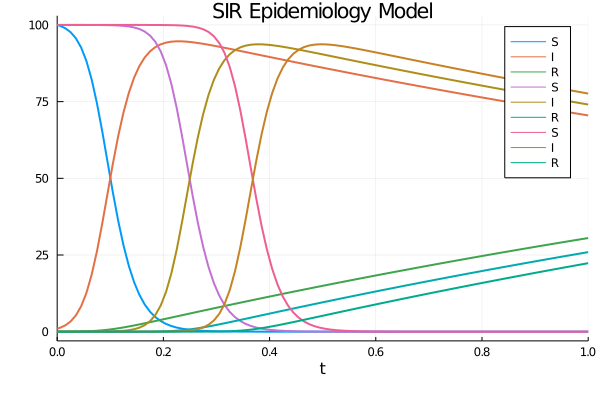

In [4]:
# Solve and plot
tspan = (0.0, 1.0)

prob = ODEProblem(threecity, u0, tspan)
sol = solve(prob, Tsit5(); dtmax = 0.01)

plot(sol, lw=2, title = "SIR Epidemiology Model", bottom_margin=10mm, left_margin=10mm,
    label=["S" "I" "R"])

## Cellular automata

 Circular port graphs are particularly useful for modeling systems where the composition pattern is given by a grid and where the dynamics are repetative. In the case of cellular automata the composition pattern is a row of $n$ cells each of which is connected to its two neighbors. The primitive systems are identical machines whose discrete dynamics are a specified rule. See [here](https://mathworld.wolfram.com/ElementaryCellularAutomaton.html) for a complete set of rules and the patterns they generate.

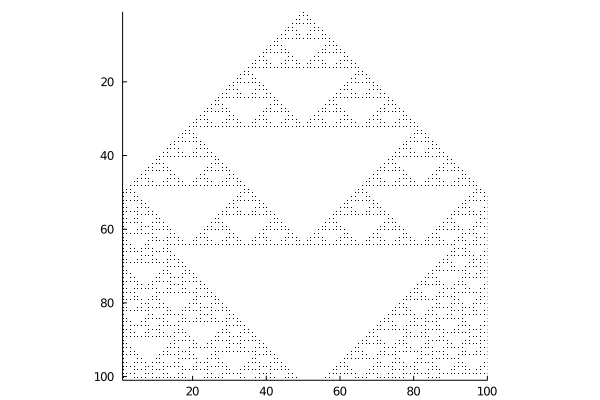

In [5]:
function Rule(k::Int)
    (left_neighbor, x, right_neighbor) ->
    Bool(digits(k, base=2, pad=8)[1 + right_neighbor + 2*x + 4*left_neighbor])
end

# Define the composition pattern
n = 100
row = apex(gridpath(n, 1))

# Define the primitive system which will be repeated for each cell
rule = DiscreteMachine{Bool}(2, 1, 2, (u, x, p, t)->Rule(p)(x[2], u[1], x[1]),
            u->[u[1], u[1]])

# Compose
automaton = oapply(row, rule)

# Solve and plot
u0 = zeros(Int, n); u0[Int(n/2)] = 1

rule_number = 126
traj = trajectory(automaton, u0, [0,0], rule_number, 100)
spy(Matrix(traj))